In [1]:
import bs4 as bs
import requests as rq
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
import re
import string
import random
import matplotlib.pyplot as plt
%matplotlib inline

# Reading the file
df = pd.read_csv("books.csv")
df.dropna(subset='Description',inplace=True)
#Reading the first five records
df.head()

#Checking the shape of the file
df.shape


(35853, 15)

In [2]:
df = df.reset_index()

In [3]:
df.head()

,index,Name,Authors,ISBN,Rating,Publisher,RatingDist5,RatingDist4,RatingDist3,RatingDist2,RatingDist1,RatingDistTotal,CountsOfReview,Language,Description,Count of text reviews
0,0,Cabinet 03: Weather,Jeffrey Kastner,1932698019,4.00,Cabinet,5:00,4:02,3:00,2:00,1:00,total:2,0,NaN,"Artwork by Joe Amrhein, Maria Blondeel, Spence...",0
1,1,"Workouts in a Binder for Swimmers, Triathletes...",Nick Hansen,1931382743,4.48,Velo Press,5:24,4:17,3:03,2:00,1:00,total:44,2,NaN,This waterproof book of 100 swimming workouts ...,2
2,2,Las 120 jornadas de Sodoma,Marquis de Sade,8472233847,3.12,TusQuets,1.420138889,1.726388889,2.163194444,1.300694444,1.019444444,total:10087,9,NaN,The 120 Days of Sodom by Marquis de Sade relat...,9
3,3,The Traveler: An American Odyssey in the Himal...,Eric Hansen,871563509,4.18,"Random House, Inc.",5:06,4:08,3:03,2:00,1:00,total:17,1,NaN,This loving memorial to Swift is a moving phot...,1
4,5,The Best Laid Plans,Sidney Sheldon,6510558,3.69,HarperCollins Publishers,3.539583333,5.6,4.88125,1.311805556,0.295833333,total:21605,28,eng,"""The Best Laid Plans"" tells the explosive stor...",28


<AxesSubplot:title={'center':'Word Count Distribution for book descriptions'}, ylabel='Frequency'>

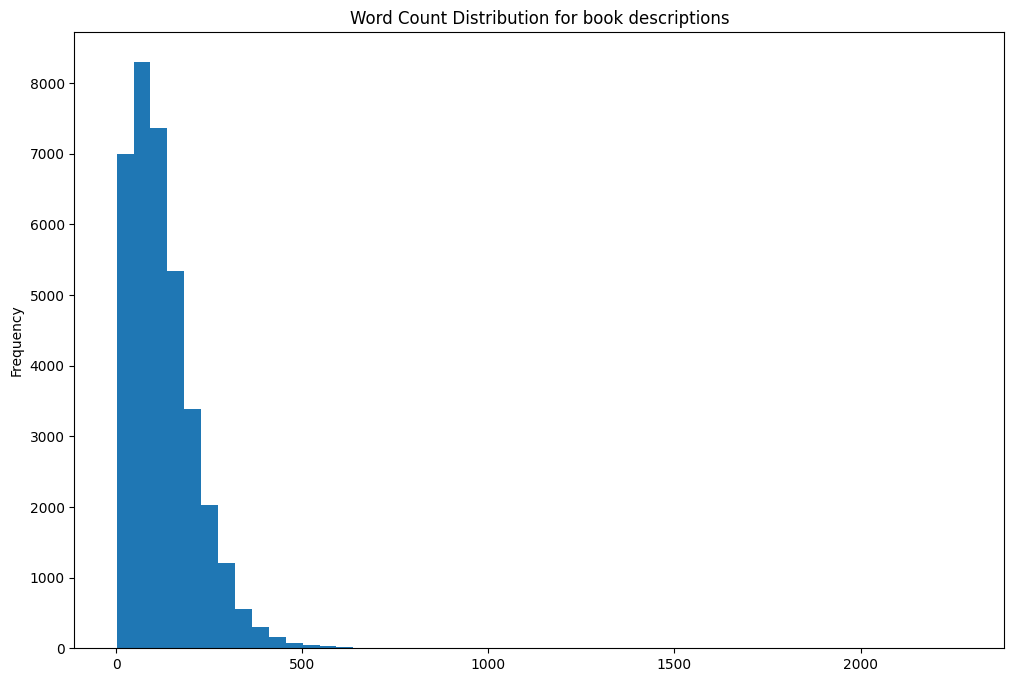

In [5]:
#Checking word count for Description.
df['word_count'] = df['Description'].apply(lambda x: len(str(x).split()))# Plotting the word count
df['word_count'].plot(
    kind='hist',
    bins = 50,
    figsize = (12,8),title='Word Count Distribution for book descriptions')

<AxesSubplot:title={'center':'Bigram disribution for the top 20 words in the book description'}, xlabel='bigram'>

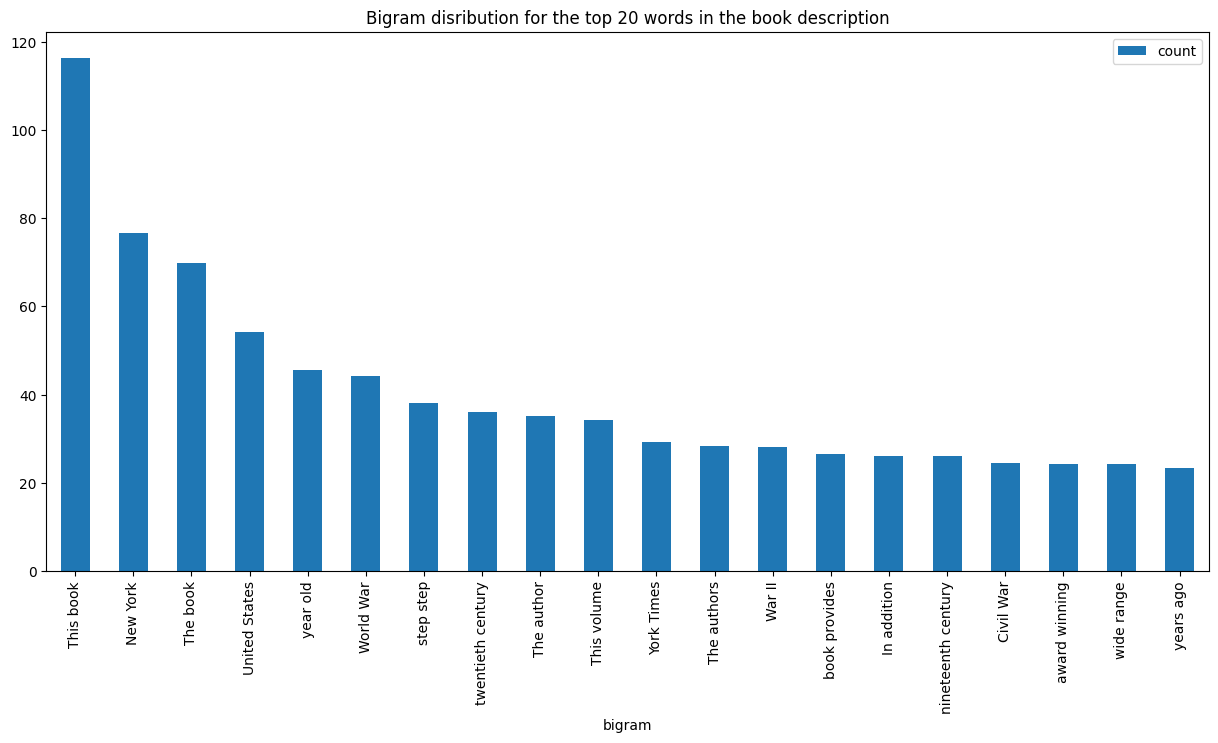

In [6]:
#Bigram Distribution For top 20 words... uncomment and run this block to check for distribution.

# tf = TfidfVectorizer(ngram_range=(2, 2), stop_words='english', lowercase = False)
# tfidf_matrix = tf.fit_transform(df['Description'])
# total_words = tfidf_matrix.sum(axis=0) 

# freq = [(word, total_words[0, idx]) for word, idx in tf.vocabulary_.items()]
# freq =sorted(freq, key = lambda x: x[1], reverse=True)

# bigram = pd.DataFrame(freq)
# bigram.rename(columns = {0:'bigram', 1: 'count'}, inplace = True) 

# bigram = bigram.head(20)


# bigram.plot(x ='bigram', y='count', kind = 'bar', title = "Bigram disribution for the top 20 words in the book description", figsize = (15,7), )

<AxesSubplot:title={'center':'Trigram disribution for the top 20 words in the book description'}, xlabel='trigram'>

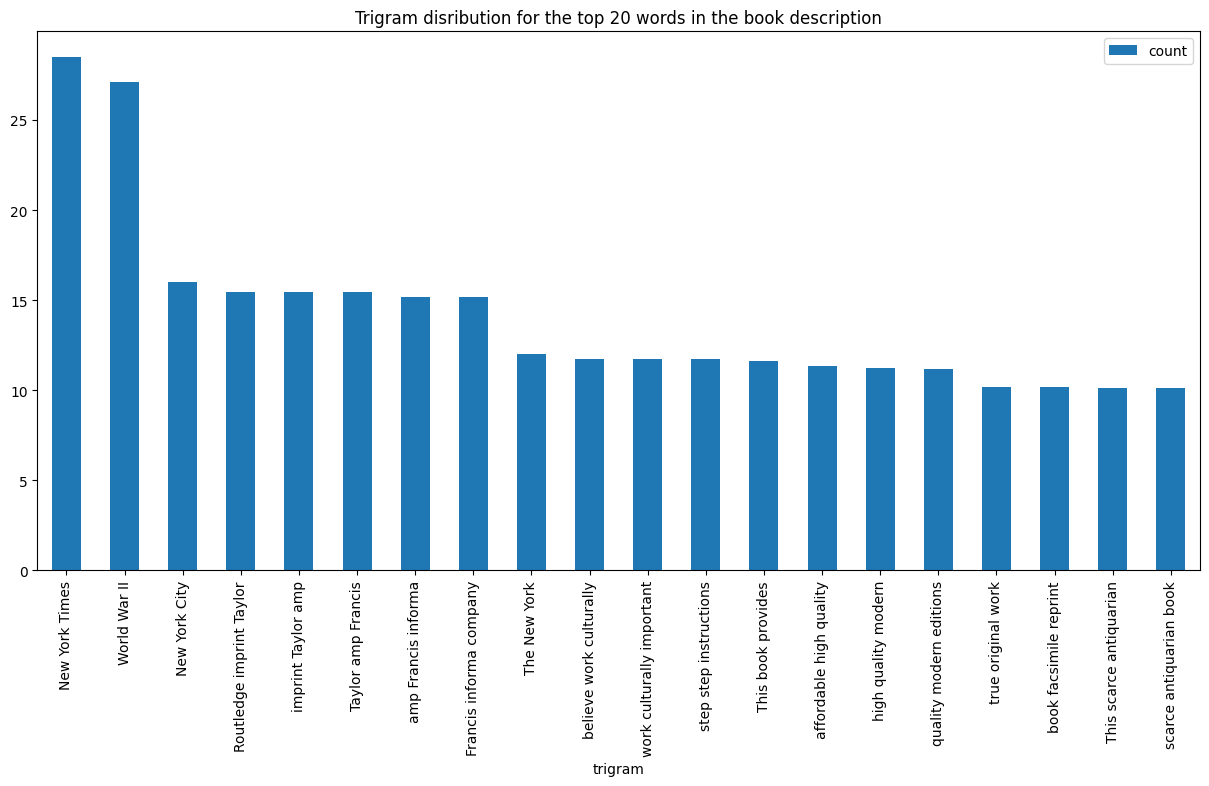

In [7]:
#Trigram Distribution For top 20 words... uncomment and run this block to check for distribution.

# tf = TfidfVectorizer(ngram_range=(3, 3), stop_words='english', lowercase = False)
# tfidf_matrix = tf.fit_transform(df['Description'])
# total_words = tfidf_matrix.sum(axis=0) 

# freq = [(word, total_words[0, idx]) for word, idx in tf.vocabulary_.items()]
# freq =sorted(freq, key = lambda x: x[1], reverse=True)
# trigram = pd.DataFrame(freq)
# trigram.rename(columns = {0:'trigram', 1: 'count'}, inplace = True) 

# trigram = trigram.head(20)


# trigram.plot(x ='trigram', y='count', kind = 'bar', title = "Trigram disribution for the top 20 words in the book description", figsize = (15,7), )

In [9]:
#Cleaning the description. removing special characters, punctuations etc.

def _removeNonAscii(s):
    return "".join(i for i in s if  ord(i)<128)

# Function for converting into lower case
def make_lower_case(text):
    return text.lower()

# Function for removing stop words
def remove_stop_words(text):
    new_stopwords = ["i", "em", "b", "p", "br"]
    text = text.split()
    stop = stopwords.words("english")
    stop.extend(new_stopwords)
    stops=set(stop)
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

# Function for removing punctuation
def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

# Function for removing the html tags
def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

# Applying all the functions in description and storing as a cleaned_desc
df['cleaned_desc'] = df['Description'].apply(_removeNonAscii)
df['cleaned_desc'] = df.cleaned_desc.apply(func = make_lower_case)
df['cleaned_desc'] = df.cleaned_desc.apply(func = remove_stop_words)
df['cleaned_desc'] = df.cleaned_desc.apply(func=remove_punctuation)
df['cleaned_desc'] = df.cleaned_desc.apply(func=remove_html)

In [13]:
df['cleaned_desc'][1002]   # random checking the description if above block worked fine.

'masks great way kids explore play fun step by step instructions book kids series make 13 unique masks featured snap create decorate whether halloween party school play dress up little imagination takes children conceal faces reveal someone new places mask designs include jolly jester dangerous dinosaur lordly lion grumpy gargoyle'

In [14]:
# Function to retrieve the description of the book if it is not present in the dataset.

def get_desc(title):
    e="https://www.goodreads.com/search?utf8=%E2%9C%93&q="
    c=rq.get(e+title)
    contents=c.content
    d=bs.BeautifulSoup(contents,"html.parser")
    title1=d.find('a',class_="bookTitle")
    new_link="https://www.goodreads.com"+title1.get('href')
    new_req=rq.get(new_link)
    new_con=new_req.content
    new_scr=bs.BeautifulSoup(new_con,'html.parser')
    data=new_scr.find("span",class_='Formatted')
    desc=data.text
    return desc

In [15]:
df['cleaned_desc']  #checking if new column is added successfully

0        artwork joe amrhein maria blondeel spencer fin...
1        waterproof book 100 swimming workouts offers s...
2        120 days sodom marquis de sade relates story f...
3        loving memorial swift moving photographic port...
4        the best laid plans tells explosive story beau...
                               ...                        
35848    donna eder professor sociology indiana univers...
35849    i gendered talk work i examines women men nego...
35850    interviews gender issues journalist jack kamme...
35851    i would rather i takes idea parlor game questi...
35852    detailed description innovative approach treat...
Name: cleaned_desc, Length: 35853, dtype: object

In [22]:
#Function to check the availability of book in dataset.

def check_availability(title):
    global df3
    if title in df['Name'].unique():
        pass
        
    else:
        df2 = {'Name': title, 'cleaned_desc':get_desc(title).lower()}
        df3=df.append(df2, ignore_index = True)
    
    return df3
    

In [23]:
# Function for recommending books based on Book description
def recommend(title):
    
#     if title not in df['Name']: 
#         df['Name']=title
#         df.at[title,'Description']=get_desc(title)
    
    global rec
    indices = pd.Series(df3.index, index = df3['Name'])
    
    tf = TfidfVectorizer(analyzer='word', ngram_range=(2, 2), min_df = 1, stop_words='english')
    tfidf_matrix = tf.fit_transform(df3['cleaned_desc'])
    
    sg = cosine_similarity(tfidf_matrix, tfidf_matrix)
    
       
    idx = indices[title]
    sig = list(enumerate(sg[idx]))
    sig = sorted(sig, key=lambda x: x[1], reverse=True)
    sig = sig[1:6]
    movie_indices = [i[0] for i in sig]
   
    # Top 5 book recommendation
    rec = df3[['Name']].iloc[movie_indices]
    print(rec)
    

In [24]:
title=input("Enter the book name: ") #Taking user input for book title
check_availability(title)            #first checks, if book is present in dataset, if not,
                                     #then immediately add book and its description to the dataset for processing.
recommend(title)                     #Recommends the book.

Enter the book name: sherlock holmes


C:\Users\mg101\AppData\Local\Temp\ipykernel_17244\747550255.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3=df.append(df2, ignore_index = True)


                                                    Name
12263           A Study in Scarlet (Sherlock Holmes, #1)
20576                      Adventures of Sherlock Holmes
23575  The Original Illustrated Sherlock Holmes (Sher...
20589                   The Case Book of Sherlock Holmes
11046                                A Study in Scarlet:
